# Exploratory data analysis 1

This notebook demonstrates that there are less images per lap with higher speeds and 
that the ground truth turning angles tend to have more extreme values with higher speeds.

## Setup
- Download and unpack training data
- Create DonkeyCar project and load configuration

In [5]:
%load_ext autoreload
%autoreload 2
import os
# do we have the correct env loaded?
assert 'donkey' == os.environ['CONDA_DEFAULT_ENV'], os.environ['CONDA_DEFAULT_ENV']

AssertionError: donkey2

In [ ]:
![ ! -d "data/" ] && \
mkdir data && \
curl -L "https://www.dropbox.com/s/eltelvjt12a4ny1/data.zip?dl=1" --output data/data.zip && \
unzip data/data.zip -d data

In [ ]:
![ ! -d "mycar/" ] && \
donkey createcar --path mycar && \
cp config/myconfig.py mycar/

In [1]:
import sys
sys.path.append('donkeycar')
sys.path.append('src')

In [2]:
import numpy as np
import donkeycar as dk
cfg = dk.load_config(config_path='mycar/config.py')
cfg.SEQUENCE_LENGTH = 0

________             ______                   _________              
___  __ \_______________  /___________  __    __  ____/_____ ________
__  / / /  __ \_  __ \_  //_/  _ \_  / / /    _  /    _  __ `/_  ___/
_  /_/ // /_/ /  / / /  ,<  /  __/  /_/ /     / /___  / /_/ /_  /    
/_____/ \____//_/ /_//_/|_| \___/_\__, /      \____/  \__,_/ /_/     
                                 /____/                              

using donkey v4.3.5 ...
loading config file: mycar/config.py
loading personal config over-rides from myconfig.py


## Is the driving speed of .9 actually different from the slower speeds of .85 and .8?
Prove that the driving speed of .9 actually was faster by
showing that there are less images per lap with higher speeds using image difference graphs

### Load tubs

In [3]:
from dataloader import load_records
from collections import OrderedDict


tubs = [
    '1-1-CC-80',
    '2-1-CW-80',
    '4-1-CC-80',
    '1-3-CC-85',
    '2-3-CW-85',
    '3-3-CW-85',
    '4-3-CC-85',
    '1-2-CC-90',
    '2-2-CW-90',
    '3-2-CW-90',
    '4-2-CC-90',
]

tub_records = OrderedDict()

for tub_name in tubs:
    tub_records[tub_name] = load_records(tub_name, cfg, 'data/')


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-1-CC-80/catalog_4.catalog



----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK
INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/1-1-CC-80']
INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/2-1-CW-80']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/2-1-CW-80/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/4-1-CC-80']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/4-1-CC-80/catalog_5.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-3-CC-85/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/1-3-CC-85']
INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/2-3-CW-85']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/2-3-CW-85/catalog_6.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/3-3-CW-85']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/3-3-CW-85/catalog_4.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/4-3-CC-85/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/4-3-CC-85']
INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/1-2-CC-90']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-2-CC-90/catalog_4.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/2-2-CW-90/catalog_2.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/2-2-CW-90']
INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/3-2-CW-90']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/3-2-CW-90/catalog_6.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/4-2-CC-90']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/4-2-CC-90/catalog_7.catalog


### Count the number of laps for each tub

In [4]:
from skimage.metrics import mean_squared_error

def mse(image1, image2):
    return np.array((image1 - image2)**2).mean()

def rmse(image1, image2):
    return np.sqrt(mse(image1, image2))

def get_diffs(images):
    return [rmse(images[0], img) for img in images]

def get_counts(diffs, lower_bound=8.8, upper_bound=9.75):
    flip = False
    counts = []
    for i, d in enumerate(diffs):
        if not flip and d < lower_bound and (len(counts) == 0 or i - counts[-1] > 165):
            flip = True
            counts.append(i)
        if flip and d > upper_bound:
            flip = False
    return np.array(counts)

def get_lengths(counts):
    return counts[1:] - counts[:-1]

def get_lengths_and_mean(images, lower_bound, upper_bound):
    diffs = get_diffs(images)
    counts = get_counts(diffs, lower_bound, upper_bound)
    lengths = get_lengths(counts)
    print(f'counts {counts} len {lengths}, mean {np.mean(lengths)}')
    assert np.mean(lengths) != np.nan
    return lengths, int(np.mean(lengths))

In [5]:
tub_bounds = [
    ('1-2-CC-90',    (9.55, 10)),
    ('2-2-CW-90',    (9.28, 10)),
    ('3-2-CW-90',    (9.25, 9.8)),
    ('4-2-CC-90',    (8.8, 10)),
    ('1-3-CC-85',    (8.8, 9.75)),
    ('2-3-CW-85',    (9.35, 10.0)),
    ('3-3-CW-85',    (8.75, 10)),
    ('4-3-CC-85',    (9.3, 10)),
    ('1-1-CC-80',    (9.25, 10.1)),
    ('2-1-CW-80',    (9.25, 10.4)),
    ('4-1-CC-80',    (8.75, 9.5)),
]

average_lap_frames = {}
image_counts = []
lengths_counts = []


for name, (lower_bound, upper_bound) in tub_bounds:
    records = tub_records[name]
    image_counts.append(len(records))
    print(name)
    images = [r.image() for r in records]
    lengths, mean = get_lengths_and_mean(images, lower_bound, upper_bound)
    lengths_counts.append(lengths)
    average_lap_frames[name] = mean

average_lap_frames

1-2-CC-90
counts [   0  290  536  808 1057 1310 1563 1756 2015 2286 2521 2767 3031 3276
 3526 3776 4017 4293 4535] len [290 246 272 249 253 253 193 259 271 235 246 264 245 250 250 241 276 242], mean 251.94444444444446
2-2-CW-90
counts [  0 225 403 626 798 985] len [225 178 223 172 187], mean 197.0
3-2-CW-90
counts [   0  222  527  758  944 1113 1366 1583 1917 2257 2524 2810 3082 3390
 3683 3876 4147 4505 4874] len [222 305 231 186 169 253 217 334 340 267 286 272 308 293 193 271 358 369], mean 270.77777777777777
4-2-CC-90
counts [   0  238  406  690  912 1127 1388 1560 1786 2150 2456 2754 3009 3238
 3470 3703 3923 4115 4433 4699 4973 5205 5422 5646 5885] len [238 168 284 222 215 261 172 226 364 306 298 255 229 232 233 220 192 318
 266 274 232 217 224 239], mean 245.20833333333334
1-3-CC-85
counts [   0  351  669 1065 1488 1918 2345 2751 3212 3673 4147] len [351 318 396 423 430 427 406 461 461 474], mean 414.7
2-3-CW-85
counts [   0  430  817 1219 1632 2030 2343 2867 3258 3696 4120 4532 

{'1-2-CC-90': 251,
 '2-2-CW-90': 197,
 '3-2-CW-90': 270,
 '4-2-CC-90': 245,
 '1-3-CC-85': 414,
 '2-3-CW-85': 422,
 '3-3-CW-85': 456,
 '4-3-CC-85': 297,
 '1-1-CC-80': 423,
 '2-1-CW-80': 425,
 '4-1-CC-80': 331}

### Compare all the frames of the tub with first frame

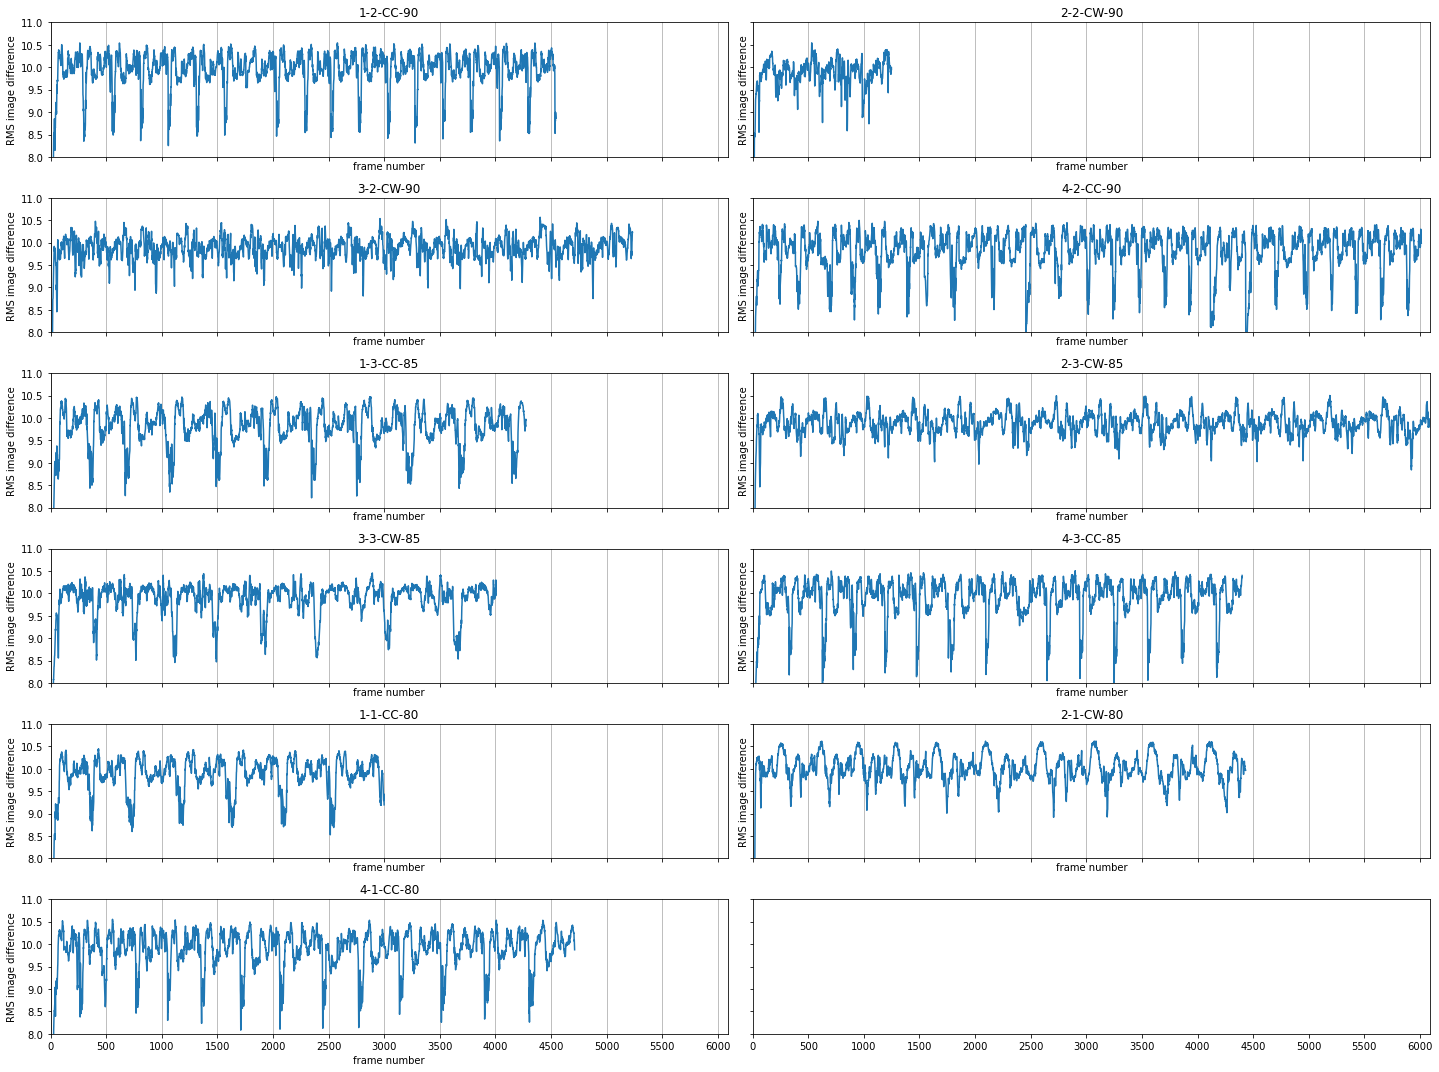

In [6]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [30/2.54, 25/2.54]
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(20, 15), sharex='all', sharey='all')

for (name, (lower_bound, upper_bound)), ax in zip(tub_bounds, axs.flat):
    records = tub_records[name]
    images = [r.image() for r in records]
    diffs = get_diffs(images)
    ax.set(title=name, xlabel='frame number', ylabel='RMS image difference')
    ax.grid(True, axis='x')
    ax.plot(diffs)

max_image_counts = max(image_counts)
ax.set(ylim=(8, 11), xlim=(0, max_image_counts), xticks=range(0, max_image_counts, 500))
fig.tight_layout()
plt.show()


### Does the frames-per-lap count differ for different speeds?

In [7]:
from collections import defaultdict

speed_averages = defaultdict(list)

for tubname, lap_average in average_lap_frames.items():
    speed_averages[tubname[-2:]].append(lap_average)
speed_averages

defaultdict(list,
            {'90': [251, 197, 270, 245],
             '85': [414, 422, 456, 297],
             '80': [423, 425, 331]})

In [8]:
{k:int(np.mean(v)) for k,v in speed_averages.items()}

{'90': 240, '85': 397, '80': 393}

### How much data do we have for each speed?

In [9]:
speed_records_count = defaultdict(list)

for tubname, records in tub_records.items():
    print(tubname, len(records))
    speed_records_count[tubname[-2:]].append(len(records))
speed_records_count

1-1-CC-80 3000
2-1-CW-80 4433
4-1-CC-80 4713
1-3-CC-85 4276
2-3-CW-85 6090
3-3-CW-85 4008
4-3-CC-85 4402
1-2-CC-90 4546
2-2-CW-90 1249
3-2-CW-90 5233
4-2-CC-90 6013


defaultdict(list,
            {'80': [3000, 4433, 4713],
             '85': [4276, 6090, 4008, 4402],
             '90': [4546, 1249, 5233, 6013]})

In [10]:
{k: sum(v) for k,v in speed_records_count.items()}

{'80': 12146, '85': 18776, '90': 17041}

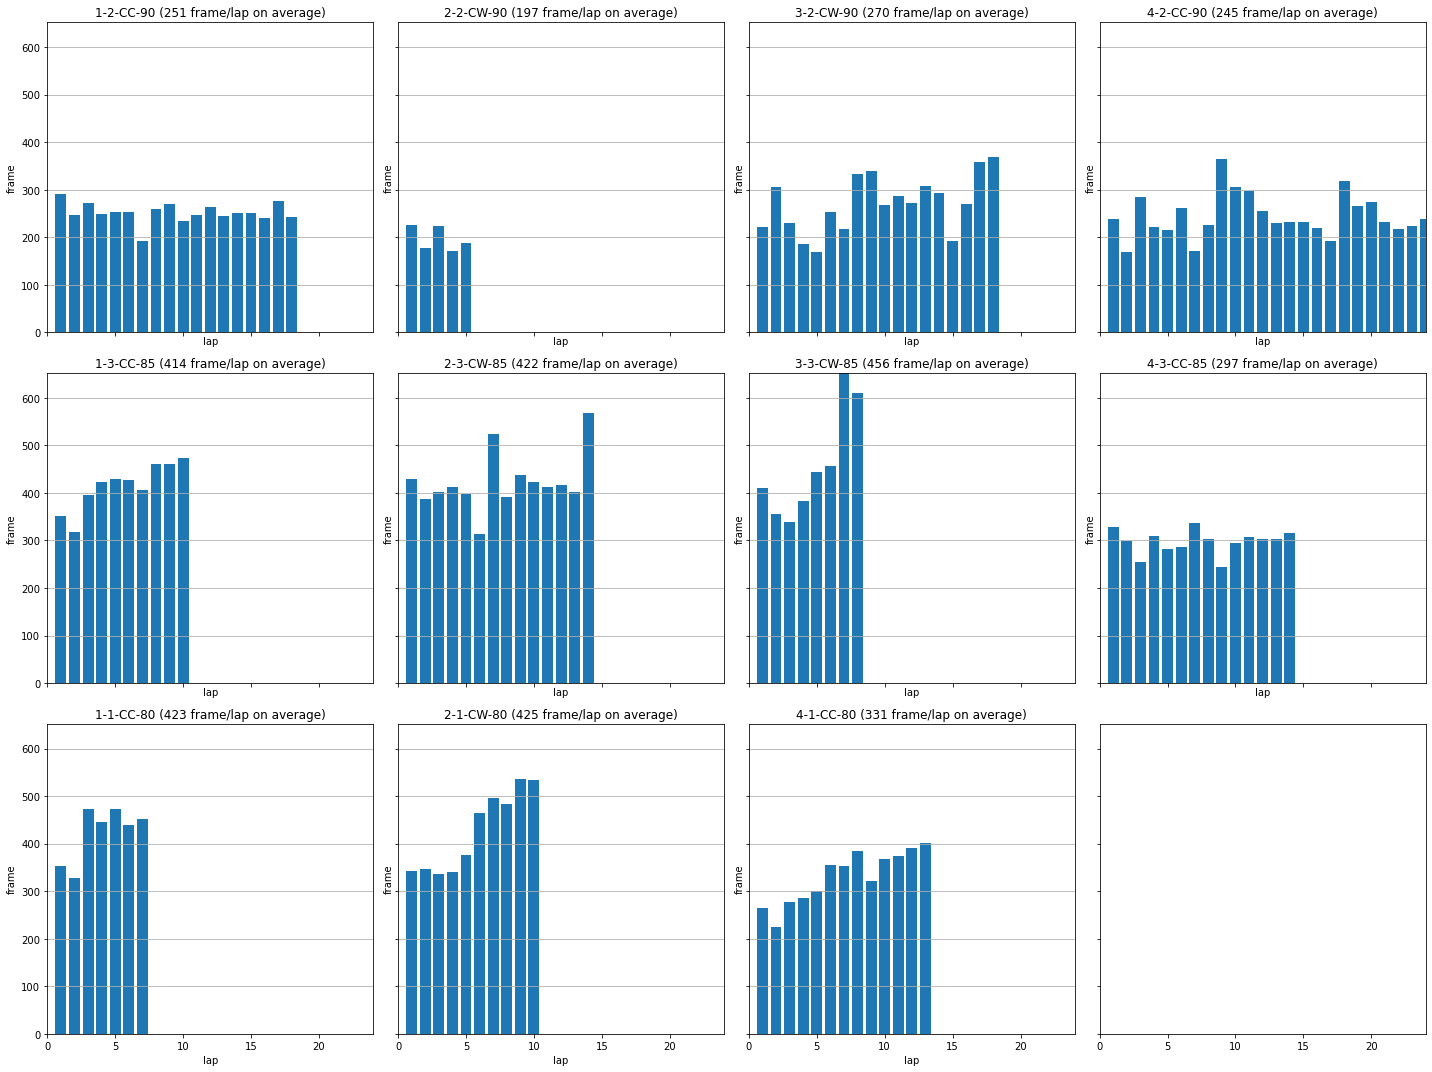

In [11]:
max_frames_per_lap = max([max(tub) for tub in lengths_counts])
max_laps = max([len(tub) for tub in lengths_counts])

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharex='all', sharey='all')

for (name, (lower_bound, upper_bound)), ax in zip(tub_bounds, axs.flat):
    records = tub_records[name]
    images = [r.image() for r in records]
    diffs = get_diffs(images)
    counts = get_counts(diffs, lower_bound, upper_bound)
    lengths = get_lengths(counts)
    ax.grid(True, axis='y')
    ax.set(title=f'{name} ({average_lap_frames[name]} frame/lap on average)', xlabel='lap', ylabel='frame')
    ax.bar(range(1, len(lengths)+1), lengths)

ax.set(ylim=(0, max_frames_per_lap), xlim=(0, max_laps))
fig.tight_layout()
plt.show()

## Are the ground truth turning angles more extreme for with higher speeds?
### Load ground truth angles

In [12]:
tub_angles = {}
for tub_name, records in tub_records.items():
    angles = [r.underlying['user/angle'] for r in records]
    tub_angles[tub_name] = angles

### How many data points are there per specific direction?

CC - Counter Clockwise and CW - ClockWise
Speeds: 80, 85 and 90

In [13]:
from collections import defaultdict
dir_speed_counts = defaultdict(int)
for k, v in tub_angles.items():
    dir_speed_counts[k[-5:]] += len(v)


dir_speed_counts = list(dir_speed_counts.items())
dir_speed_counts.sort()
dir_speed_counts

[('CC-80', 7713),
 ('CC-85', 8678),
 ('CC-90', 10559),
 ('CW-80', 4433),
 ('CW-85', 10098),
 ('CW-90', 6482)]

Let's demonstrate that higher speeds have more extreme ground truth turning angles.

In [14]:
from collections import OrderedDict
from matplotlib import pyplot as plt

def get_angles_for_direction(tub_angles, direction):
    direction_tub_angles = {k: v for k, v in tub_angles.items() if direction in k}
    direction_tub_angles = OrderedDict(sorted(list(direction_tub_angles.items()), key=lambda k: k[0][-2:]))
    direction_angles_by_speed = OrderedDict()
    for k, v in direction_tub_angles.items():
        if direction_angles_by_speed.get(k[-2:]):
            direction_angles_by_speed[k[-2:]].extend(v)
        else:
            direction_angles_by_speed[k[-2:]] = v
    return direction_angles_by_speed

def plot_all(name, tub_angles):
    plt.figure()
    hist, bins, _ = plt.hist(tub_angles.values(), bins=9, density=True)
    plt.title(name)
    plt.legend(tub_angles.keys())
    plt.xlabel('angle')
    plt.ylabel('count')
    plt.grid()
    plt.show()
    return hist

### Counter clockwise direction histogram

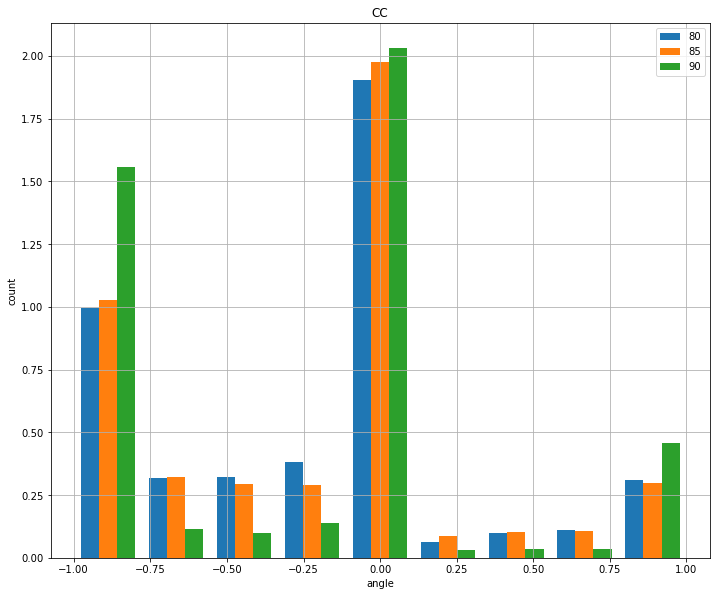

In [15]:
direction = 'CC'
hist = plot_all(direction, get_angles_for_direction(tub_angles, direction))

### Clockwise direction histogram

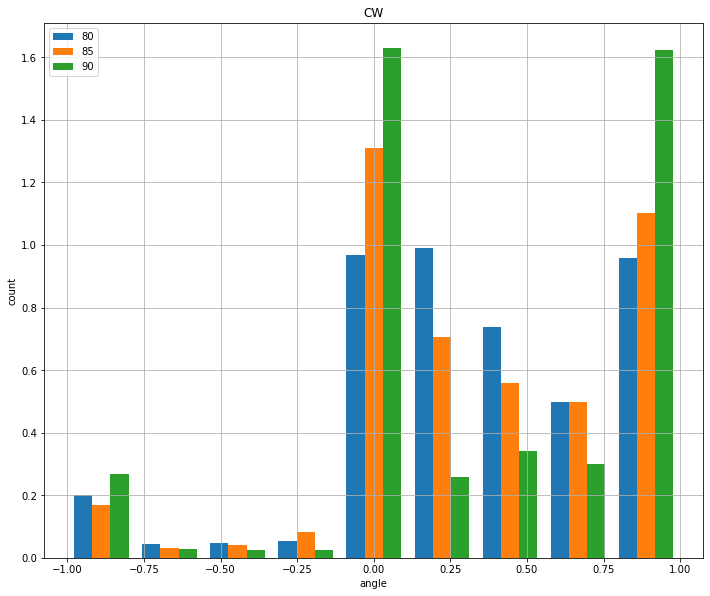

In [16]:
direction = 'CW'
hist = plot_all(direction, get_angles_for_direction(tub_angles, direction))